Todos:

1) dataset: splitting by folds, and traiing on particular folds only?
vs.
training on all data, irespective of fold. get the same training dataset as the pevious 2 papers. take the redo-database 19436 structures for training of which 300 are held out.

- sample sequences randomly throughout the training sequences to not bias towards surface residues.

- sample residues according to their frequency in the PDB dataset to not bias towards rare amino acids like Cys.

- proper dataset objects, and batches of datasets. maybe try 20 examples at a time like 

- expanding the number of atoms to look at?

features:
- orienting all the atoms correctly wrt their position. take the bisector and make a right angle
- add partial charges and solvent accessibility.
- add H-atoms? https://bioinformatics.stackexchange.com/questions/17916/how-can-i-programmatically-add-hydrogen-to-a-pdb-structure-using-biopython


model:

1) only have connections between a central node and the surrounding atoms. 

2) graph attention networks? so that can pay attention to particular atoms in vicinity. Can you learn atoms?

3) better ways to learn interactions between atoms? look at siman batzner 

4) rotation equivariant filters instead?


Parameters to gridscan#
- number of atoms in neighborhood to look at.
- batch size, learning rate, etc.

In [ ]:
import torch_scatter
import torch_cluster

import torch_sparse
import torch_geometric
import Bio

OSError: ignored

# get pdb coordinates

In [ ]:
from Bio.PDB import *
import numpy as np
import bisect
import matplotlib.pyplot as plt
import random





O [1. 0. 0. 0.] O
N [0. 1. 0. 0.] N
C [0. 0. 1. 0.] C
S [0. 0. 0. 1.] S


In [ ]:


pdbl = PDBList() 
pdbl.retrieve_pdb_file('5CEG', pdir = '.', file_format = 'pdb')

parser = PDBParser(PERMISSIVE = True, QUIET = True) 
data = parser.get_structure("5CEG","pdb5ceg.ent")


Structure exists: './pdb5ceg.ent' 


In [ ]:
'''
model = data.get_models()
models = list(model)
type(models[0])
print(models)

chains = list(models[0].get_chains())
chains

chains[0]._id

residue = list(chains[0].get_residues())
len(residue)
residue1 = list(chains[1].get_residues())
len(residue1)

residue = list(chains[0].get_residues())
residue[2].__dict__

atoms = list(residue[0].get_atoms())
atoms

atoms[1].__dict__

atoms[1].get_vector()


residue[-1].id
'''

[<Model id=0>]


<Vector -36.24, -66.58, -56.58>

1.118033988749895

In [ ]:



pdbl = PDBList() 
pdbl.retrieve_pdb_file('5CEG', pdir = '.', file_format = 'pdb')
parser = PDBParser(PERMISSIVE = True, QUIET = True) 
data = parser.get_structure("5CEG","pdb5ceg.ent")
model = list(data.get_models())[0]
coords_oi, neighbors, label = get_atoms_neighbor(model, 'A', 10)
print(coords_oi)
print(neighbors)
print(label)

Structure exists: './pdb5ceg.ent' 
[array([-18.229, -54.942, -56.574], dtype=float32), array([-16.799, -54.709, -56.478], dtype=float32), array([-16.334, -54.926, -55.041], dtype=float32)]
[('O', array([-17.358, -49.744, -55.545], dtype=float32), 5.0827355), ('SD', array([-13.262, -51.321, -54.227], dtype=float32), 5.3903537), ('OE1', array([-20.605, -50.897, -57.962], dtype=float32), 5.587418), ('OE2', array([-19.828, -49.874, -56.191], dtype=float32), 5.7126546), ('OG', array([-15.262, -49.792, -59.063], dtype=float32), 5.7638073), ('CD', array([-20.047, -49.923, -57.411], dtype=float32), 5.8588214), ('O', array([-14.959, -48.724, -56.545], dtype=float32), 6.2618146), ('CE', array([-11.778, -51.725, -53.326], dtype=float32), 6.6370025), ('O', array([-22.817, -51.91 , -56.781], dtype=float32), 6.6439843), ('CG', array([-13.557, -49.65 , -53.611], dtype=float32), 6.6576056), ('CG', array([-19.612, -48.733, -58.253], dtype=float32), 6.8393083), ('CB', array([-14.567, -49.266, -60.181], 

In [ ]:

print(set([n[0][0] for n in neighbors]))

{'O', 'N', 'C', 'S'}


Structure exists: './pdb5ceg.ent' 
[<Model id=0>]


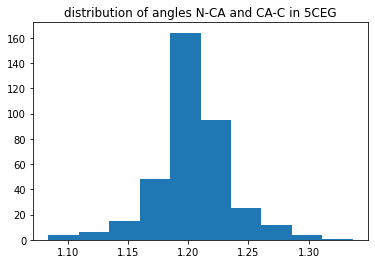

In [ ]:
# check what the N-ca, ca-c angles are across different residues. How similar are these angles?

all_angles = []

pdbl = PDBList() 
pdbl.retrieve_pdb_file('5CEG', pdir = '.', file_format = 'pdb')
parser = PDBParser(PERMISSIVE = True, QUIET = True) 
data = parser.get_structure("5CEG","pdb5ceg.ent")
model = data.get_models()
models = list(model)
print(models)
chains = list(models[0].get_chains())
for chain_oi in chains:
    residues = list(chain_oi.get_residues())
    for res_oi in residues:  
        if res_oi.id[0] == ' ':
            #print(res_oi.full_id)
            atoms_oi = list(res_oi.get_atoms())
            #print(atoms_oi)
            n_oi = [atom for atom in atoms_oi if atom.id == 'N'][0]
            ca_oi = [atom for atom in atoms_oi if atom.id == 'CA'][0]
            c_oi = [atom for atom in atoms_oi if atom.id == 'C'][0]

            n_oi_coord = n_oi.coord
            ca_oi_coord = ca_oi.coord
            c_oi_coord = c_oi.coord

            angle = angle_2_vecs(n_oi_coord-ca_oi_coord, ca_oi_coord-c_oi_coord)
            all_angles.append(angle)


plt.figure()
plt.hist(all_angles)
plt.title('distribution of angles N-CA and CA-C in 5CEG')
plt.show()


In [ ]:
import timeit

In [ ]:




get_stand_coords(np.array([1,0,0]),
                 np.array([0,0,0]),
                 np.array([0,1,0]),
                 np.array([3,4,5]))

array([3., 4., 5.])

In [ ]:
# take 100 random residues, get their neighbors and coordinates, transform them, get their labels
# and make a training dataset.


def get_x_train(model, n_res):

    chains = list(model.get_chains())

    all_residues=[]
    for chain in chains:
        all_residues += chain.get_residues()

    res_wo_het = [res for res in all_residues if res.id[0] == ' ']

    random_residues = random.choices(res_wo_het, k=n_res)
    print(len(random_residues))
    print(random_residues)

    all_ns = []
    all_y = []
    for res in random_residues:
        chain = res.full_id[2] # full id is ('5CEG', 0, 'C', (' ', 10, ' '))
        resn = res.full_id[3][1]
        bb_coords, ns, label =  get_atoms_neighbor(model, chain, resn, n_neighbours = 80)

        # concatenate all these
        # get the one hot encoding of amino acid types
        x_atom = np.stack([atom_to_oh(n[0][0]) for n in ns])

        # todo: transform each neighbor into new coordinates
        x_pos = np.stack([n[1] - np.array(bb_coords) for n in ns])
        x_pos.shape

        # append the distnces
        x_d = np.array([n[2] for n in ns]).T
        x_d = x_d.reshape(-1,1)
        x_d.shape

        x_all = np.concatenate([ x2, x1, x_d], axis=1)
        x_all.shape
                

        # transform label into single letter codes.
        #y = aa_to_oh(label)
        y = aa_to_idx(label)

        all_ns.append(x_all)
        all_y.append([y])

    return all_ns, all_y

pdb_id = '5CEG'
pdbl = PDBList() 
pdbl.retrieve_pdb_file(pdb_id, pdir = '.', file_format = 'pdb')
parser = PDBParser(PERMISSIVE = True, QUIET = True) 
data = parser.get_structure(pdb_id,"pdb"+pdb_id.lower()+".ent")
models = list(data.get_models())
print(models)
m= models[0]

all_x, all_y = get_x_train(m,100)


Structure exists: './pdb5ceg.ent' 
[<Model id=0>]
100
[<Residue ARG het=  resseq=68 icode= >, <Residue ARG het=  resseq=58 icode= >, <Residue GLY het=  resseq=82 icode= >, <Residue ARG het=  resseq=101 icode= >, <Residue PHE het=  resseq=103 icode= >, <Residue VAL het=  resseq=84 icode= >, <Residue PRO het=  resseq=71 icode= >, <Residue GLU het=  resseq=74 icode= >, <Residue GLU het=  resseq=66 icode= >, <Residue LYS het=  resseq=45 icode= >, <Residue ALA het=  resseq=16 icode= >, <Residue ARG het=  resseq=49 icode= >, <Residue ASP het=  resseq=78 icode= >, <Residue ALA het=  resseq=39 icode= >, <Residue ALA het=  resseq=76 icode= >, <Residue LEU het=  resseq=15 icode= >, <Residue VAL het=  resseq=65 icode= >, <Residue ASP het=  resseq=31 icode= >, <Residue LEU het=  resseq=44 icode= >, <Residue GLU het=  resseq=38 icode= >, <Residue ARG het=  resseq=96 icode= >, <Residue ASN het=  resseq=3 icode= >, <Residue ASP het=  resseq=31 icode= >, <Residue LEU het=  resseq=85 icode= >, <Residue

In [ ]:
len(x)

100

In [ ]:
# making a fully connected edge index between all 80 atoms
n_nodes = x[0].shape[0]
n_nodes

r2 = np.repeat(np.array(range(n_nodes)), n_nodes) # gives [0,0,0, ..., 79, 79, 79]
r1 = np.array(list(range(n_nodes))*n_nodes) # gives [0,1,2,3, ... 77, 78, 79]

edge_index = np.stack([r1, r2])


In [ ]:
'''
pdbl = PDBList() 
pdbl.retrieve_pdb_file('5CEG', pdir = '.', file_format = 'pdb')
parser = PDBParser(PERMISSIVE = True, QUIET = True) 
data = parser.get_structure("5CEG","pdb5ceg.ent")
model = list(data.get_models())[0]

bb_coords, ns, label = get_atoms_neighbor(model, 'A', 10, n_neighbours = 80)
ns[0]
'''

Structure exists: './pdb5ceg.ent' 


('O', array([-17.358, -49.744, -55.545], dtype=float32), 5.0827355)

# proteinnet

In [ ]:
# make a message passing layer that has
#node features: position+atom type + distance to amino acid of interest
#edge features: distances between atoms

In [ ]:

from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool

# this is very much like the edge conv layer in the example:
#https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

class ProteinNetLayer1(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_index):
        # Message passing with "max" aggregation.
        super(ProteinNetLayer1, self).__init__('max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        # in channels *2 so can concatenate the neighbor node feature and the satial relation
        self.mlp = Sequential(Linear(in_channels +3, out_channels), # 32 out dimensions for each datapoint
                              ReLU(), # applying relu elementwise. maintains 32 out dimensions
                              Linear(out_channels, out_channels))
        self.edge_index = edge_index
        
    def forward(self, h, x):
        # Start propagating messages.
        # initial call to propagate, takes edge_indices and all additional data 
        # to construct messages and update node embeddings
        #can do bipartite graphs too by passing a tuple.

        # propagate() internally calls 
        #   message()   defined below
        #   aggregate() defined above by 'max'
        #   update():   update node embeddings in analogy to gamma. takes output 
        #               of aggregation as first argument and any arguent which was 
        #               initially passed to propagate()
        edge_index = self.edge_index
        return self.propagate(edge_index, h=h, x=x) 
    
    def message(self, h_j, x_j, x_i):
        # constructs messages to node i in analogy to phy for each edge
        # can take any argument that was initially passed to propagated
        # in addition, tensors passed to propagate() can be mapped to the respectives
        # nodes i and j by appending _i or _j.


        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]. this is a lifted tensor.
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3], so is shape [20480 = 10* 128 * 16, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3], so is shape [20480 = 10* 128 * 16, 3]
        
        input = x_j[:,:3] - x_i[:,:3]  # Compute spatial relation between all 2 nodes
        #print(input.shape)
        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            #print(h_j.shape, h_j)
            input = torch.cat([h_j, input], dim=-1)
        #print(input.shape)
        return self.mlp(input)  # Apply our final MLP.

class ProteinNet1(torch.nn.Module):
    def __init__(self, in_dims, out_dims, edge_index):
        super(ProteinNet1, self).__init__()

        torch.manual_seed(12345)
        self.conv1 = ProteinNetLayer1(in_dims, 32, edge_index)
        self.conv2 = ProteinNetLayer1(32, 32, edge_index)
        self.classifier = Linear(32, out_dims)
        
    def forward(self, x, batch):
        # pos is the [10*128=1280, 3] position vector # 128 samples per example
        # batch is [1280] vector that says which point belongs to which example ([0,0,0, ... , 9,9])
        # and this function call returns the output of classifier (the linear output)


        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        #edge_index = knn_graph(pos, k=16, batch=batch, loop=True) 
        # edge_index is a [2,16*128 * 10= 20480] matrix saying which 2 nodes are connected
        
        # 3. Start bipartite message passing.
        # h will change, but position doesn't
        h = self.conv1(h=x, x=x) # passing it the positions, and connections.
        h = h.relu() # what does this do?
        h = self.conv2(h=h, x=x)
        h = h.relu()

        # 4. Global Pooling.
        #print('x_shape', x.shape)
        #print('h_shape', h.shape)
        
        h = global_max_pool(h, batch = batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)


model = ProteinNet1(in_dims =8, out_dims = len(alphabet), edge_index = torch.from_numpy(edge_index))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, x, y):
    model.train()
    
    total_loss = 0
    optimizer.zero_grad()  # Clear gradients.

    batch = torch.tensor([0]*x.shape[0])
    #print(batch.shape)
    logits = model(x.float(), batch)  # Forward pass.
    #print('logits',logits.shape, logits)
    loss = criterion(logits, y)  # Loss computation.
    #print('loss', loss)
    loss.backward()  # Backward pass.
    optimizer.step()  # Update model parameters.
    total_loss += loss.item()

    return total_loss / len(x)


for epoch in range(0, len(all_x)):
    x_train = torch.from_numpy(all_x[epoch])
    y_train = torch.from_numpy(np.array(all_y[epoch]))
    #print('y_train',y_train.shape, y_train)
    #print('x_train', x_train.shape)
    loss = train(model, optimizer, x_train, y_train)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 00, Loss: 0.0290
Epoch: 01, Loss: 0.0069
Epoch: 02, Loss: 0.1140
Epoch: 03, Loss: 0.0005
Epoch: 04, Loss: 0.0580
Epoch: 05, Loss: 0.0444
Epoch: 06, Loss: 0.0538
Epoch: 07, Loss: 0.0513
Epoch: 08, Loss: 0.0426
Epoch: 09, Loss: 0.0474
Epoch: 10, Loss: 0.0422
Epoch: 11, Loss: 0.0299
Epoch: 12, Loss: 0.0474
Epoch: 13, Loss: 0.0355
Epoch: 14, Loss: 0.0337
Epoch: 15, Loss: 0.0447
Epoch: 16, Loss: 0.0270
Epoch: 17, Loss: 0.0394
Epoch: 18, Loss: 0.0410
Epoch: 19, Loss: 0.0306
Epoch: 20, Loss: 0.0315
Epoch: 21, Loss: 0.0536
Epoch: 22, Loss: 0.0311
Epoch: 23, Loss: 0.0327
Epoch: 24, Loss: 0.0302
Epoch: 25, Loss: 0.0416
Epoch: 26, Loss: 0.0544
Epoch: 27, Loss: 0.0310
Epoch: 28, Loss: 0.0298
Epoch: 29, Loss: 0.0371
Epoch: 30, Loss: 0.0278
Epoch: 31, Loss: 0.0557
Epoch: 32, Loss: 0.0254
Epoch: 33, Loss: 0.0295
Epoch: 34, Loss: 0.0317
Epoch: 35, Loss: 0.0286
Epoch: 36, Loss: 0.0305
Epoch: 37, Loss: 0.0550
Epoch: 38, Loss: 0.0363
Epoch: 39, Loss: 0.0336
Epoch: 40, Loss: 0.0270
Epoch: 41, Loss:

In [ ]:
# Example of target with class indices # this works.
from torch import nn
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
print(input)
print(target)

tensor([[-1.3405, -0.2251,  0.2040,  0.8747,  0.1143],
        [-0.5788,  0.8519,  1.8421, -1.1253,  0.2136],
        [ 2.6940,  0.8644,  0.4634,  0.0028, -2.2809]], requires_grad=True)
tensor([3, 2, 4])


In [ ]:

# Example of target with class probabilities # this doesn't work.
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
print(input)
print(target)
output = loss(input, target)
output.backward()

tensor([[-1.5514, -1.0154,  0.4368,  0.1970,  0.0982],
        [ 0.9143, -0.3493, -1.7955,  0.0173, -0.8788],
        [ 1.9122,  0.1722,  1.2774,  0.2898,  0.6558]], requires_grad=True)
tensor([[0.4159, 0.1464, 0.1386, 0.1604, 0.1388],
        [0.2023, 0.1465, 0.2610, 0.2095, 0.1807],
        [0.1899, 0.1788, 0.0505, 0.3830, 0.1978]])


RuntimeError: ignored

In [ ]:
torch.from_numpy(edge_index)


torch.Size([2, 6400])

## example point net 

In [ ]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool

# this is very much like the edge conv layer in the example:
#https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super(ProteinNetLayer, self).__init__('max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        # in channels *2 so can concatenate the neighbor node feature and the satial relation
        self.mlp = Sequential(Linear(in_channels *2, out_channels), 
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        # initial call to propagate, takes edge_indices and all additional data 
        # to construct messages and update node embeddings
        #can do bipartite graphs too by passing a tuple.

        # propagate() internally calls 
        #   message()   defined below
        #   aggregate() defined above by 'max'
        #   update():   update node embeddings in analogy to gamma. takes output 
        #               of aggregation as first argument and any arguent which was 
        #               initially passed to propagate()

        return self.propagate(edge_index, h=h, pos=pos) 
    
    def message(self, h_j, pos_j, pos_i):
        # constructs messages to node i in analogy to phy for each edge
        # can take any argument that was initially passed to propagated
        # in addition, tensors passed to propagate() can be mapped to the respectives
        # nodes i and j by appending _i or _j.


        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]. this is a lifted tensor.
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3], so is shape [20480 = 10* 128 * 16, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3], so is shape [20480 = 10* 128 * 16, 3]
        
        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.




class PointNet(torch.nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, batch):
        # pos is the [10*128=1280, 3] position vector # 128 samples per example
        # batch is [1280] vector that says which point belongs to which example ([0,0,0, ... , 9,9])
        # and this function call returns the output of classifier (the linear output)


        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True) 
        # edge_index is a [2,16*128 * 10= 20480] matrix saying which 2 nodes are connected
        
        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index) # passing it the positions, and connections.
        h = h.relu() # what does this do?
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

NameError: ignored

# train test